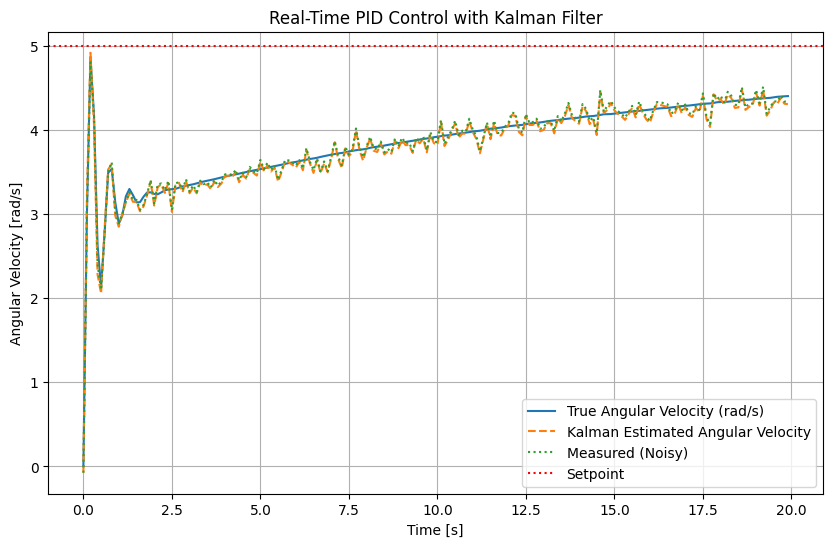

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# DC motor parameters
R = 2.0    # Resistance (Ohms)
L = 0.5    # Inductance (H)
Ke = 0.01  # Back-EMF constant (V/rad/s)
Kt = 0.01  # Torque constant (Nm/A)
J = 0.01   # Moment of inertia (kg.m^2)
B = 0.1    # Friction coefficient (Nms)

# State-space matrices
A = np.array([[-R/L, -Ke/L], [Kt/J, -B/J]])
B = np.array([[1/L], [0]])
C = np.array([[0, 1]])  # We only measure the angular velocity (omega)
D = np.array([[0]])

# Time step for real-time simulation
dt = 0.1  # Time step (s)
simulation_time = 20  # Total time for simulation (seconds)

# PID controller parameters
Kp = 30  # Proportional gain
Ki = 3  # Integral gain
Kd = 0.3 # Derivative gain

# Initialize PID variables
integral = 0
previous_error = 0

# Setpoint for the angular velocity
setpoint = 5.0  # Desired angular velocity (rad/s)

# Initial conditions
x = np.array([[0], [0]])  # Initial state [current, angular velocity]

# Add noise to the angular velocity measurements
measurement_noise_std = 0.1  # Noise standard deviation

# Kalman filter variables
Q = np.diag([0.001, 0.001])  # Process noise covariance
R_kalman = np.array([[measurement_noise_std**2]])  # Measurement noise covariance
P = np.eye(2)  # Error covariance
x_est_k = np.array([[0], [0]])  # Initial state estimate

# Data for real-time plotting
true_velocity_data = []
estimated_velocity_data = []
measured_velocity_data = []
time_data = []
control_input_data = []

# Real-time simulation loop
for t in np.arange(0, simulation_time, dt):
    # True system dynamics
    x_dot = A @ x + B * (Kp * (setpoint - x[1, 0]) + Ki * integral + Kd * (previous_error))
    x = x + x_dot * dt
    true_velocity = x[1, 0]

    # Measured (noisy) angular velocity
    y_measured = true_velocity + np.random.normal(0, measurement_noise_std)

    # Kalman filter prediction step
    x_pred = A @ x_est_k + B * (Kp * (setpoint - x_est_k[1, 0]) + Ki * integral + Kd * (previous_error))
    P_pred = A @ P @ A.T + Q

    # Kalman gain
    S = C @ P_pred @ C.T + R_kalman
    K = P_pred @ C.T @ np.linalg.inv(S)

    # Kalman filter measurement update
    y_pred = C @ x_pred
    x_est_k = x_pred + K @ (y_measured - y_pred)
    P = (np.eye(2) - K @ C) @ P_pred

    # Calculate the error
    error = setpoint - y_measured
    integral += error * dt  # Update the integral term
    derivative = error - previous_error  # Calculate the derivative
    previous_error = error  # Update previous error

    # Control input using PID
    control_input = Kp * error + Ki * integral + Kd * derivative

    # Store results for plotting
    time_data.append(t)
    true_velocity_data.append(true_velocity)
    measured_velocity_data.append(y_measured)
    estimated_velocity_data.append(x_est_k[1, 0])
    control_input_data.append(control_input)

    # Clear the previous output
    clear_output(wait=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(time_data, true_velocity_data, label='True Angular Velocity (rad/s)')
    plt.plot(time_data, estimated_velocity_data, label='Kalman Estimated Angular Velocity', linestyle='--')
    plt.plot(time_data, measured_velocity_data, label='Measured (Noisy)', linestyle='dotted')
    plt.axhline(y=setpoint, color='r', linestyle=':', label='Setpoint')
    plt.title("Real-Time PID Control with Kalman Filter")
    plt.xlabel('Time [s]')
    plt.ylabel('Angular Velocity [rad/s]')
    plt.legend()
    plt.grid()
    plt.show()

    # Simulate real-time processing delay
    time.sleep(dt)
